In [9]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd '/content/drive/My Drive/Colab Notebooks/EVA_P2/S4'


/content/drive/My Drive/Colab Notebooks/EVA_P2/S4


In [11]:
import dlib
import cv2 
# import faceBlendCommon as fbc
import numpy as np
# from datapath import DATA_PATH
# from datapath import MODEL_PATH
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
matplotlib.rcParams['figure.figsize']=(6.0, 6.0)
matplotlib.rcParams['image.cmap']='gray'

def writeLandmarksToFile(landmarks, landmarksFileName):
  with open(landmarksFileName, 'w') as f:
    for p in landmarks.parts():
      f.write("%s %s\n", (int(p.x), int(p.y)))
  f.close()


#Landmark model location
PREDICTION_PATH = "shape_predictor_5_face_landmarks.dat"


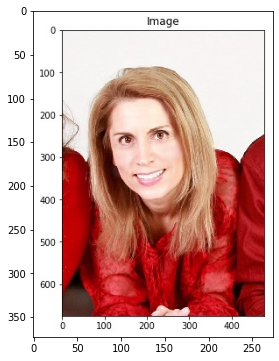

In [13]:

#get the face detector instance
faceDetector = dlib.get_frontal_face_detector()
# the landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTION_PATH)

#Read image
imageFilename = "face.jpg"
im = cv2.imread(imageFilename)
# im=cv2.cvtColor(imageFilename, cv2.COLOR_RGB2BGR)

plt.imshow(im[:,:,::-1])
plt.show()



In [14]:
faceRects =faceDetector(im,0)

print("Number of faces detected",len(faceRects))

lanmarksall=[]

Number of faces detected 1


In [17]:
#!/usr/bin/python
# Copyright 2017 BIG VISION LLC ALL RIGHTS RESERVED
#
# This code is made available to the students of
# the online course titled "Computer Vision for Faces"
# by Satya Mallick for personal non-commercial use.
#
# Sharing this code is strictly prohibited without written
# permission from Big Vision LLC.
#
# For licensing and other inquiries, please email
# spmallick@bigvisionllc.com
#
import cv2
import dlib
import numpy as np
import math

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffine2D(np.array([inPts]), np.array([outPts]), False)
  # print("tform", tform.shape)
  return tform

# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  eyecornerSrc = [pointsIn[2], pointsIn[0]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  # print("tfrom", type(tform))
  # print("tform shape",tform.shape)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)
  # print("Im shape",imIn.shape)
  # print("Im shape",tform.shape)
  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform[0], dsize=(w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))
  
  # Apply similarity transform to landmarks
  # pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  # pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))
  pointsOut = cv2.transform(points2,tform[0])

  return imOut, pointsOut


# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points


# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points


In [18]:
#Detect Landmarks 
points = getLandmarks(faceDetector,landmarkDetector, im )
points = np.array(points)

#converts images into floating point inthe range of 0 to 1
im = np.float32(im)/255.0


shape (373, 274, 3)


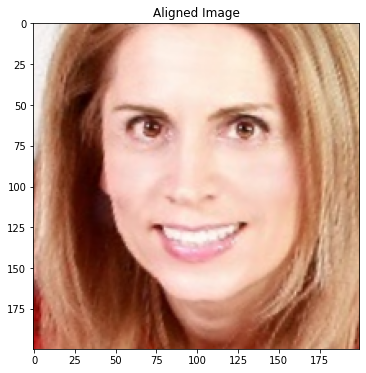

In [19]:
  #Dimensions of the output image
  h = 200
  w = 200

  #Normalize the image to output coordinates
  imNorm, points = normalizeImagesAndLandmarks((h,w), im, points)

  imNorm = np.uint8(imNorm*255)

  #display the results
  plt.imshow(imNorm[:,:,::-1])
  plt.title("Aligned Image")
  plt.show()